In [5]:
# Import libraries
import pandas as pd
import numpy as np
import os
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import shapiro, kstest
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Feature Engineering

In [6]:
# Read in topospace CSV files

# Read in X matrix
X = pd.read_csv ('/rds/homes/s/sxc1561/Thesis/X_matrix.csv')

# Define the filenames and corresponding variable names
file_names = [
    'DNA', 'LINE', 'Low_complexity', 'LTR', 'Other', 'RC', 'RNA',
    'rRNA', 'Satellite', 'scRNA', 'Simple_repeat', 'SINE', 
    'snRNA', 'srpRNA', 'tRNA', 'Unknown'
]

file_path = '/rds/homes/s/sxc1561/Thesis/repeats_csv/'

# Read in repeat CSV files and store in a dictionary
repeat_dfs = {name: pd.read_csv(os.path.join(file_path, f'{name}.csv'), index_col=0) for name in file_names}

# Function to convert matrix to values
def matrix_to_values(matrix):
    values = []
    rows, cols = matrix.shape  # Number of rows and columns

    for i in range(rows):
        for j in range(i + 1, cols):  # Ensure j > i to avoid duplicates
            values.append(matrix.iloc[i, j])

    return values

# Convert matrices to vectors and take log
log_values = {}
for name, matrix in repeat_dfs.items():
    vector = matrix_to_values(matrix)
    log_values[name] = np.log(vector)

# Access the log-transformed vectors using log_values['DNA'], log_values['LINE'], etc.

In [7]:
# Add each log vector as a new column in X
for name, log_vector in log_values.items():
    X[name] = log_vector

In [8]:
# Save as CSV
#X.to_csv('X_repeats_topospace.csv', index=False)

In [9]:
# Add y 
ESC = pd.read_csv('ESC_new.csv', index_col=0)
y = np.log(matrix_to_values(ESC))

### Correlation Analysis

In [10]:
# Check correlation

correlations = X.corr()
#print(correlations)

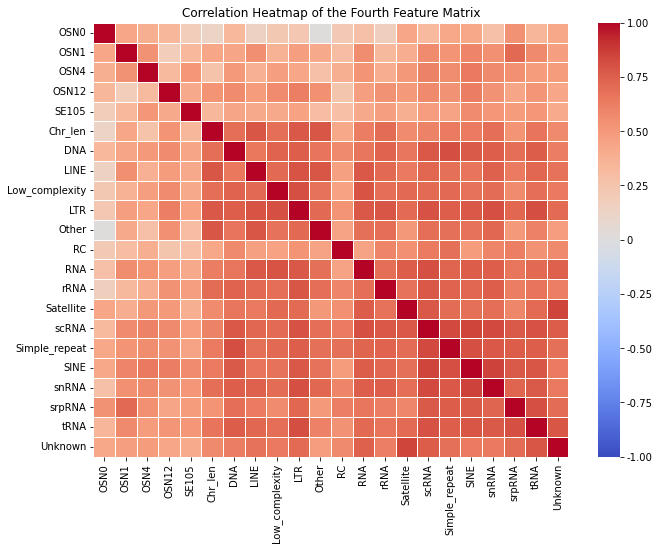

In [11]:
# Plot correlation heatmap

plt.figure(figsize=(10, 8))  # Set the size of the heatmap

# Create the heatmap with the desired settings
heatmap = sns.heatmap(correlations, annot=False, cmap='coolwarm', linewidths=0.5, center=0, vmin=-1, vmax=1)

# Create a custom colorbar with the desired ticks
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
colorbar.set_ticklabels(['-1.00', '-0.75', '-0.50', '-0.25', '0', '0.25', '0.50', '0.75', '1.00'])

# Add title and adjust layout
plt.title('Correlation Heatmap of the Fourth Feature Matrix')
plt.tight_layout(pad=2.0)  # Adjust layout

# Save the plot with tight bounding box and higher resolution
#plt.savefig('fourth_corr_hm.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Regression Analysis

In [12]:
# Use Random Forest with X and y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for test data
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f'Training Mean Squared Error: {train_mse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Test Mean Squared Error: {test_mse:.2f}')
print(f'Test R-squared: {test_r2:.2f}')

# Feature importance
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print('Feature Importances:')
print(importance_df)

Training Mean Squared Error: 0.00
Training R-squared: 0.98
Test Mean Squared Error: 0.01
Test R-squared: 0.83
Feature Importances:
           Feature  Importance
15           scRNA    0.308112
16   Simple_repeat    0.251020
9              LTR    0.118702
8   Low_complexity    0.048365
13            rRNA    0.045405
7             LINE    0.039001
6              DNA    0.038357
12             RNA    0.026545
18           snRNA    0.018016
19          srpRNA    0.017701
20            tRNA    0.017087
10           Other    0.012150
17            SINE    0.009686
11              RC    0.007871
3            OSN12    0.007776
4            SE105    0.006100
0             OSN0    0.005528
5          Chr_len    0.005456
2             OSN4    0.004600
14       Satellite    0.004242
21         Unknown    0.004165
1             OSN1    0.004115


### Feature Importance

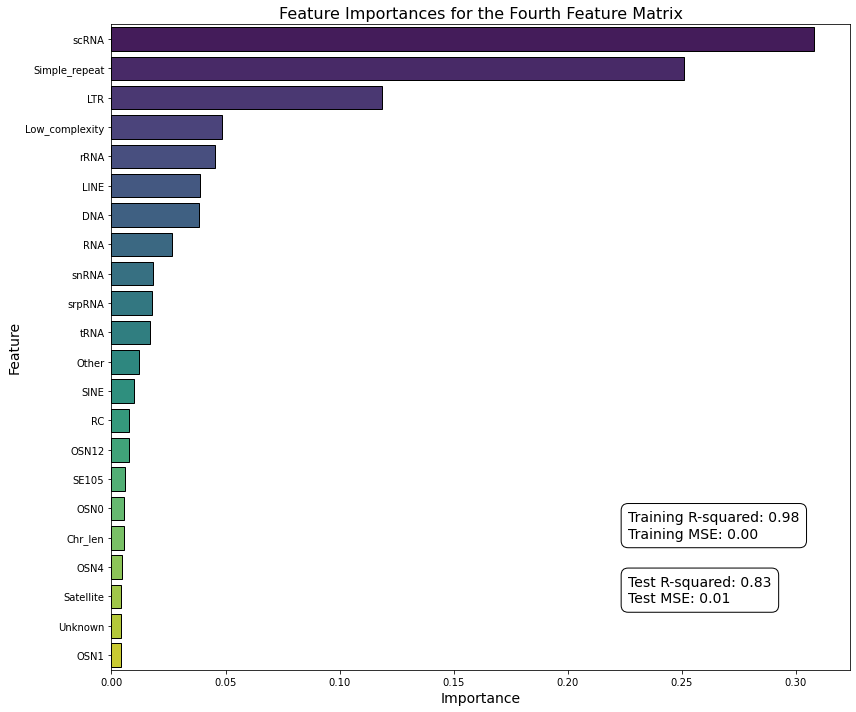

In [13]:
# Plot feature importances 
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', edgecolor='black')

plt.title('Feature Importances for the Fourth Feature Matrix', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Add text boxes with evaluation metrics at the bottom of the plot
plt.text(0.7, 0.2, f'Training R-squared: {train_r2:.2f}\nTraining MSE: {train_mse:.2f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.text(0.7, 0.1, f'Test R-squared: {test_r2:.2f}\nTest MSE: {test_mse:.2f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.tight_layout()
#plt.savefig('Fourth_matrix_importance.jpg', dpi=300, bbox_inches='tight')
plt.show()


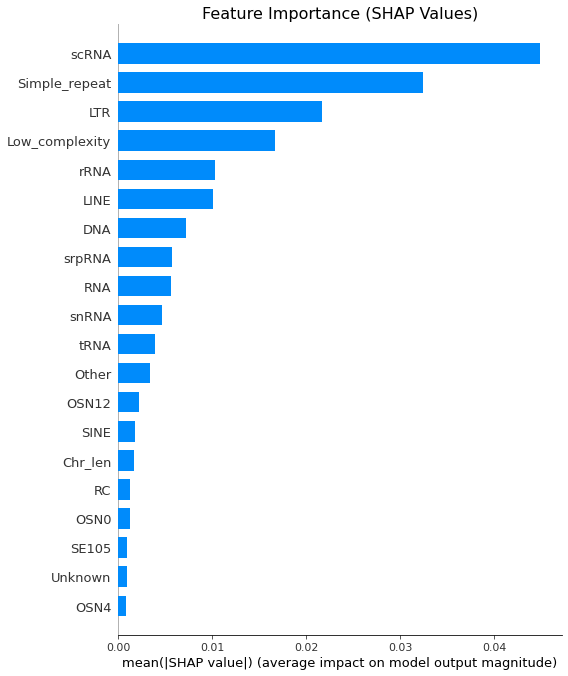

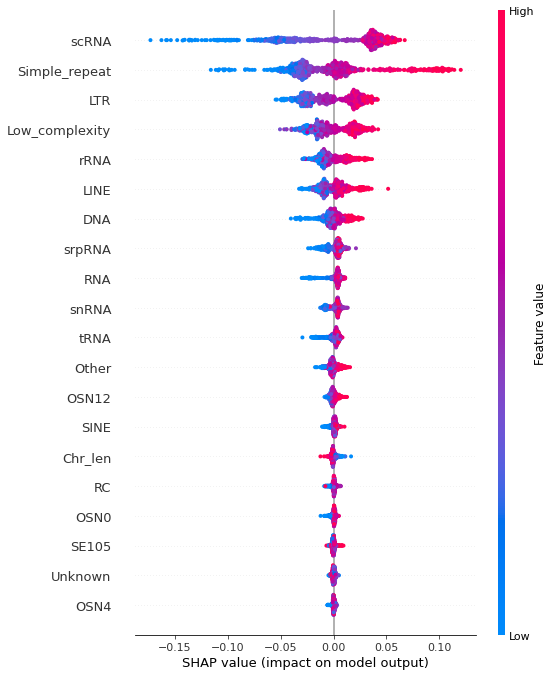

In [14]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Plot the summary of SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title('Feature Importance (SHAP Values)', fontsize=16)
plt.tight_layout()

# Save the plot as a JPEG file with higher resolution (dpi)
#plt.savefig('SHAP.jpg', dpi=300)
plt.show()

# Create the SHAP summary plot
shap.summary_plot(shap_values, X, show=False)

# Save the plot
#plt.savefig('fourth_shap_summary_plot.jpg', dpi=300, bbox_inches='tight')
plt.show() 

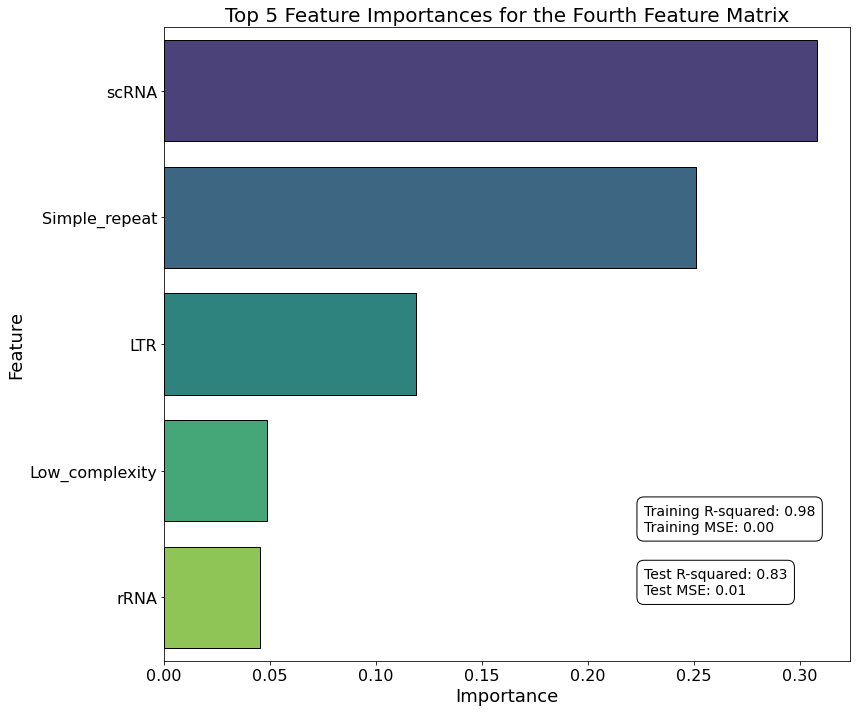

In [15]:
# Sort importance_df to get the top 5 most important features
top_5_importance_df = importance_df.sort_values(by='Importance', ascending=False).head(5)

# Plot the top 5 feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=top_5_importance_df, palette='viridis', edgecolor='black')

plt.title('Top 5 Feature Importances for the Fourth Feature Matrix', fontsize=20)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)

# Increase font size of the feature names on the y-axis
plt.yticks(fontsize=16)
# Increase font size of the importance values on the x-axis
plt.xticks(fontsize=16)

# Add text boxes with evaluation metrics at the bottom of the plot
plt.text(0.7, 0.2, f'Training R-squared: {train_r2:.2f}\nTraining MSE: {train_mse:.2f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.text(0.7, 0.1, f'Test R-squared: {test_r2:.2f}\nTest MSE: {test_mse:.2f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.tight_layout()
plt.savefig('Top_5_fourth_matrix_importance.jpg', dpi=300, bbox_inches='tight')
plt.show()

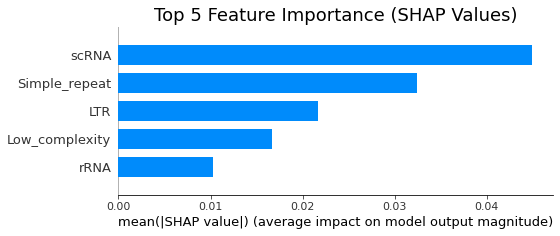

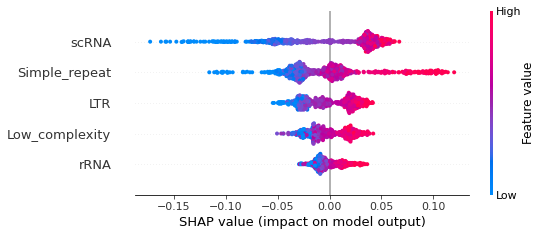

In [16]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Calculate mean absolute SHAP values for each feature to find the top 5
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_5_indices = np.argsort(mean_abs_shap)[-5:]  # Get indices of top 5 features

# Filter the SHAP values and the corresponding feature names for the top 5
shap_values_top_5 = shap_values[:, top_5_indices]
X_top_5 = X.iloc[:, top_5_indices]

# Increase font sizes globally
plt.rcParams.update({'font.size': 14})

# Plot the summary of SHAP values for the top 5 features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_top_5, X_top_5, plot_type="bar", show=False)
plt.title('Top 5 Feature Importance (SHAP Values)', fontsize=18)
plt.tight_layout()

# Save the plot as a JPEG file with higher resolution (dpi)
#plt.savefig('SHAP_top_5.jpg', dpi=300)
plt.show()

# Create the SHAP summary plot for the top 5 features
shap.summary_plot(shap_values_top_5, X_top_5, show=False)

# Save the plot
plt.savefig('fourth_top_5_shap_summary_plot.jpg', dpi=300, bbox_inches='tight')
plt.show() 